# Dependencias

In [273]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.8.2)
     |████████████████████████████████| 1.3MB 2.8MB/s 
     |████████████████████████████████| 63.8MB 60kB/s 
     |████████████████████████████████| 27.7MB 152kB/s 
     |████████████████████████████████| 204.7MB 67kB/s 
     |████████████████████████████████| 1.5MB 39.8MB/s 
     |████████████████████████████████| 10.1MB 41.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 29.3MB 163kB/s 
     |████████████████████████████████| 1.3MB 47.4MB/s 
     |████████████████████████████████| 204kB 46.3MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 819kB 42.5MB/s 
     |████████████████████████████████| 153kB 52.6MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 727kB 46.2MB/s 
     |████████████████████████████████| 2.7MB 46.2MB/s 
     |███████████████

In [274]:
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from graphviz import Source
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn.compose import TransformedTargetRegressor
from google.colab import files

import io
import datetime 
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams

In [3]:
fuploaded = files.upload()

Saving DATA_RETO_2_ACT.csv to DATA_RETO_2_ACT.csv


In [4]:
fuploaded2 = files.upload()

Saving goverment-measures-dataset-v2.csv to goverment-measures-dataset-v2.csv


In [5]:
def evaluate(model, X, Y):
    strat_k_fold = KFold(n_splits=3, shuffle=True, random_state=2020)
    mae = make_scorer(mean_absolute_error)
    return np.mean(cross_val_score(model, X, Y, scoring = mae, cv = strat_k_fold))

# Exploratory Data Analysis

In [354]:
df = pd.read_csv(io.BytesIO(fuploaded['DATA_RETO_2_ACT.csv']), encoding = 'iso-8859-1')

In [355]:
df.head()

,country,country_code,iso,date,continent,who_region,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,cumulative_cases
0,Afghanistan,AF,AFG,12/4/20,Asia,EMRO,48,33.0000,65.0000,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,555
1,Albania,AL,ALB,9/4/20,Europe,EURO,31,41.1533,20.1683,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,409
2,Algeria,DZ,DZA,2/4/20,Africa,AFRO,37,28.0339,1.6596,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,1,847
3,Andorra,AD,AND,14-04-2020,Europe,EURO,43,42.5063,1.5218,77265,163.755,44.9,16.180,0.000,42029.760,NaN,109.135,7.97,29.0,37.8,NaN,0.00,83.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,651
4,Angola,AO,AGO,3/5/20,Africa,AFRO,43,-11.2027,17.8739,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,0.00,61.15,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,35


In [356]:
df.describe()

,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,cumulative_cases
count,201.000000,201.000000,201.000000,2.010000e+02,201.000000,201.000000,201.000000,196.000000,201.000000,119.000000,196.000000,196.000000,138.000000,138.000000,90.000000,196.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,42.054726,20.427803,15.010914,3.837301e+07,341.201905,31.494527,9.439562,5.127107,22873.111731,13.589076,236.332918,7.717449,10.419565,31.877536,50.776456,2.520806,72.773781,0.666667,0.238806,0.626866,0.402985,0.656716,0.671642,0.114428,0.756219,0.457711,0.741294,0.691542,0.741294,0.114428,0.059701,0.119403,0.184080,2256.865672
std,11.716740,24.339263,60.228550,1.455073e+08,1502.658289,9.266926,6.526246,4.334029,26692.554648,20.237760,128.119404,4.385913,10.462340,14.060708,32.025371,2.514958,10.420260,0.472582,0.427418,0.484845,0.491723,0.475991,0.470788,0.319125,0.430434,0.499452,0.439017,0.463010,0.439017,0.319125,0.237525,0.325072,0.388517,7456.216983
min,30.000000,-51.796300,-106.346800,8.090000e+02,0.000000,15.100000,1.144000,0.000000,314.540000,0.100000,0.000000,0.000000,0.100000,0.000000,1.188000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
25%,35.000000,6.611100,-11.779889,1.271767e+06,37.312000,23.300000,3.556000,1.795000,5321.444000,0.550000,149.612500,4.887500,1.900000,21.025000,19.728000,0.700000,67.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.000000
50%,39.000000,18.335000,17.873900,7.132530e+06,87.324000,31.900000,7.104000,3.345500,14048.881000,2.200000,233.423000,7.110000,6.050000,30.900000,49.690500,1.950000,75.050000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,308.000000
75%,46.000000,41.153300,44.000000,2.769102e+07,222.873000,39.600000,14.864000,8.577750,32605.906000,21.300000,310.649500,10.105000,19.025000,40.875000,82.589500,3.600000,78.880000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1135.000000
max,109.000000,71.706900,178.065000,1.439324e+09,19347.500000,53.800000,33.150000,18.493000,185741.280000,77.600000,724.417000,23.360000,44.000000,78.100000,98.999000,13.800000,86.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,61049.000000


In [357]:
df.dtypes

country                                        object
country_code                                   object
iso                                            object
date                                           object
continent                                      object
who_region                                     object
day_of_infection                                int64
latitude                                      float64
longitude                                     float64
population                                      int64
population_density                            float64
median_age                                    float64
aged_65_older                                 float64
aged_70_older                                 float64
gdp_per_capita                                float64
extreme_poverty                               float64
cvd_death_rate                                float64
diabetes_prevalence                           float64
female_smokers              

In [358]:
df.isna().sum()

country                                         0
country_code                                    1
iso                                             0
date                                            0
continent                                       0
who_region                                      0
day_of_infection                                0
latitude                                        0
longitude                                       0
population                                      0
population_density                              0
median_age                                      0
aged_65_older                                   0
aged_70_older                                   5
gdp_per_capita                                  0
extreme_poverty                                82
cvd_death_rate                                  5
diabetes_prevalence                             5
female_smokers                                 63
male_smokers                                   63


In [359]:
fig = px.treemap(df, path=['country'], values='cumulative_cases',
                  color='population_density', hover_data=['continent'],
                  color_continuous_scale='matter', title='Cumulative Cases')
fig.show()

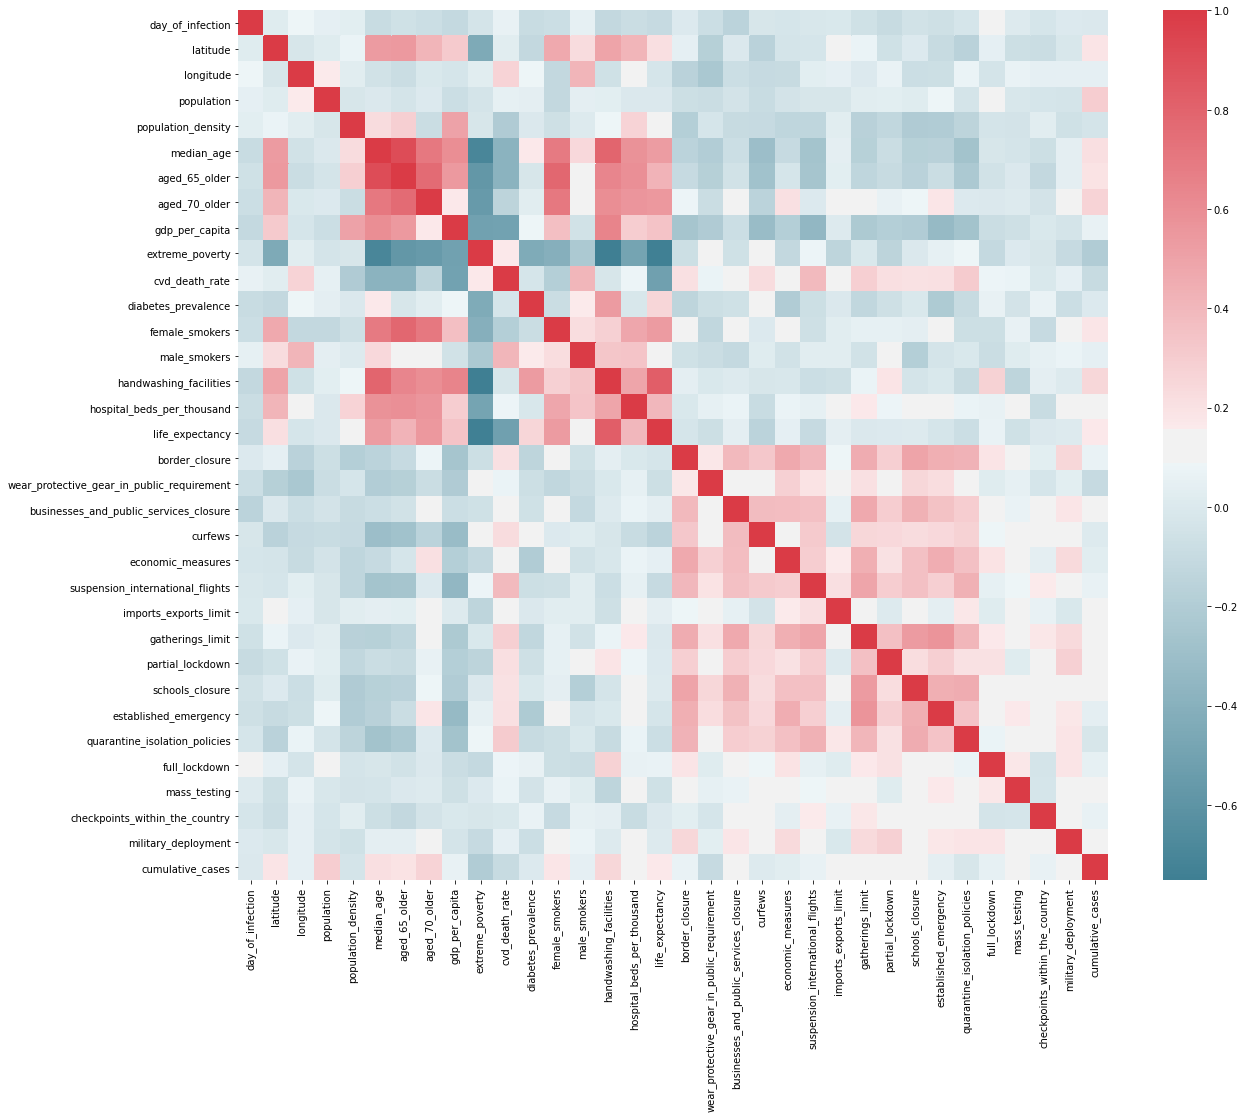

In [360]:
f, ax = plt.subplots(figsize=(20, 16))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae8244f7f0>,
      dtype=object)

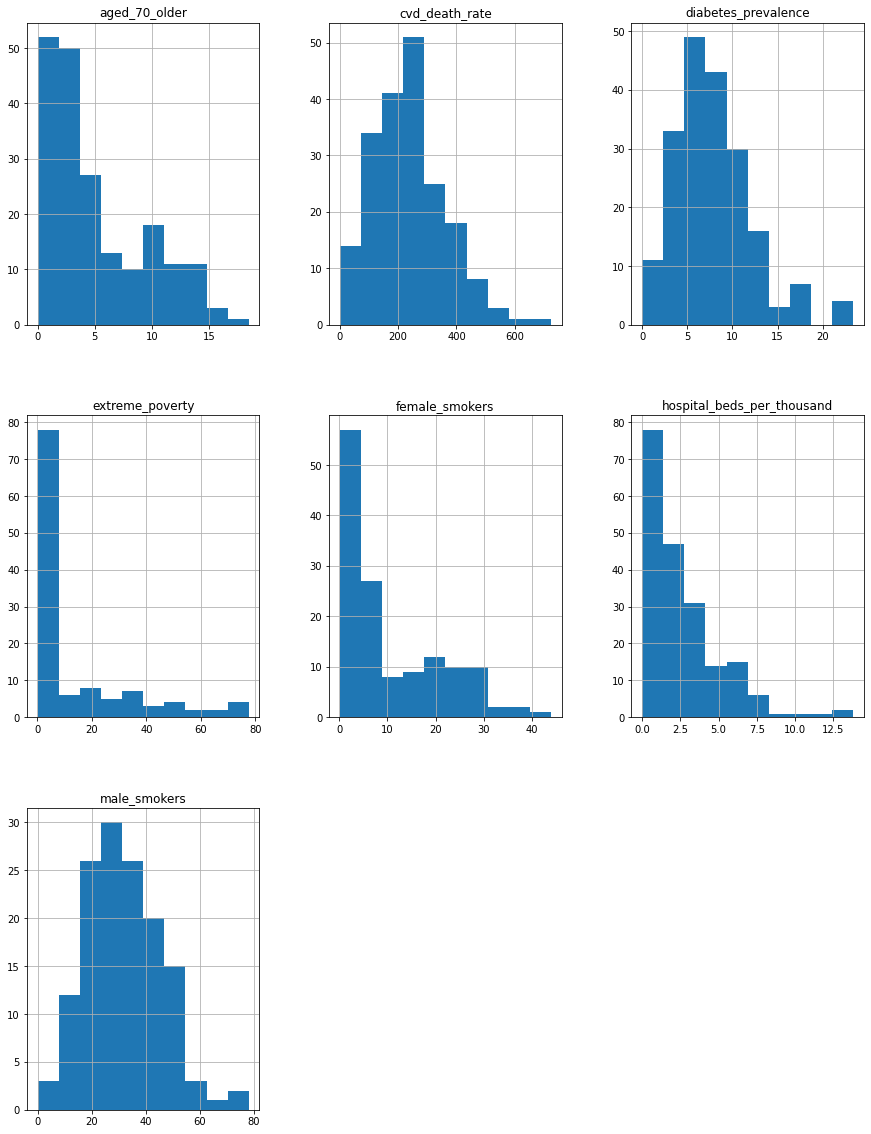

In [361]:
df[['extreme_poverty', 'cvd_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'hospital_beds_per_thousand', 'aged_70_older']].hist(figsize = (15,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae7b0a86d8>,
      dtype=object)

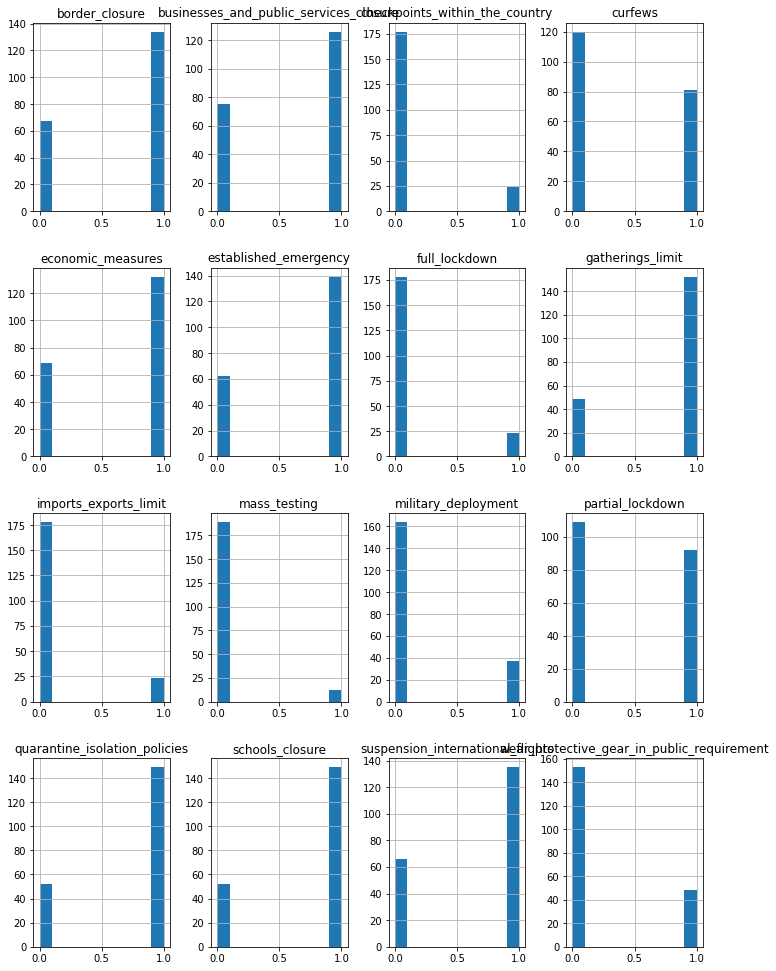

In [362]:
df[['border_closure', 'wear_protective_gear_in_public_requirement', 'businesses_and_public_services_closure', 'curfews', 'economic_measures', 'suspension_international_flights', 'imports_exports_limit', 'gatherings_limit', 'partial_lockdown', 'schools_closure', 'established_emergency', 'quarantine_isolation_policies', 'full_lockdown', 'mass_testing', 'checkpoints_within_the_country', 'military_deployment']].hist(figsize = (12,17))

# Feature Engineering

In [363]:
# Dates related features
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear
df['quarter'] = df['date'].dt.quarter
df['weekofyear'] = df['date'].dt.weekofyear

def weekend_count(date, day_of_infection):
  s = 0
  for i in range(1, day_of_infection):
    t = date - datetime.timedelta(days=i)
    w = t.weekday()
    # 5 - SAT / 6 - SUNDAY
    if w >= 5:
      s += 1
  return s

def public_holidays_count(country_code, date, day_of_infection):
  start_date = date - datetime.timedelta(days=day_of_infection)

  ph = PublicHolidays(country_code, start_date, end_date=date)
  df_holidays = ph.to_pandas_dataframe()
  return df_holidays.shape[0] if df_holidays is not None else 0

df['weekend_count'] = np.apply_along_axis(lambda x: weekend_count(x[0], x[1]), 1, df[['date', 'day_of_infection']])

In [364]:
# Null related features
df['handwashing_facilities_isnull'] = df.apply(
    lambda row: 1 if np.isnan(row['handwashing_facilities']) else 0,
    axis=1
)

In [365]:
# Covid related features
df_measures = pd.read_csv(io.BytesIO(fuploaded2['goverment-measures-dataset-v2.csv']), encoding = 'iso-8859-1')
df_measures['DATE_IMPLEMENTED'] = pd.to_datetime(df_measures['DATE_IMPLEMENTED'])
df_measures.dropna(thresh=7)
df_measures.head()

,ï»¿ID,COUNTRY,ISO,ADMIN_LEVEL_NAME,PCODE,REGION,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
0,1.0,Afghanistan,AFG,NaN,NaN,Asia,Public health measures,Health screenings in airports and border cross...,No,NaN,NaN,2020-12-02,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,14/03/2020,NaN
1,2.0,Afghanistan,AFG,Kabul,NaN,Asia,Public health measures,Introduction of quarantine policies,No,NaN,NaN,2020-12-02,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,14/03/2020,NaN
2,3.0,Afghanistan,AFG,NaN,NaN,Asia,Public health measures,Awareness campaigns,No,NaN,NaN,2020-12-02,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,14/03/2020,NaN
3,4.0,Afghanistan,AFG,NaN,NaN,Asia,Social and economic measures,Emergency administrative structures activated ...,No,NaN,NaN,2020-12-02,Ministry of Health,Government,https://moph.gov.af/en/moph-held-emergency-mee...,14/03/2020,NaN
4,5.0,Afghanistan,AFG,NaN,NaN,Asia,Social distancing,Limit public gatherings,No,Nevruz festival cancelled,NaN,2020-12-03,AA,Media,https://www.aa.com.tr/en/asia-pacific/coronavi...,14/03/2020,NaN


In [366]:
df_measures_count = df_measures[df_measures['DATE_IMPLEMENTED'] < '2020-02-03'].groupby('ISO').count()['DATE_IMPLEMENTED']
df = df.set_index('iso').join(df_measures_count).reset_index()
df.rename(columns={'DATE_IMPLEMENTED':'measures_before_march'}, inplace=True)
df.head()

,iso,country,country_code,date,continent,who_region,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,cumulative_cases,day,month,dayofweek,dayofyear,quarter,weekofyear,weekend_count,handwashing_facilities_isnull,measures_before_march
0,AFG,Afghanistan,AF,2020-12-04,Asia,EMRO,48,33.0000,65.0000,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,555,4,12,4,339,4,49,13,0,5.0
1,ALB,Albania,AL,2020-09-04,Europe,EURO,31,41.1533,20.1683,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,409,4,9,4,248,3,36,8,1,NaN
2,DZA,Algeria,DZ,2020-02-04,Africa,AFRO,37,28.0339,1.6596,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,1,847,4,2,1,35,1,6,10,0,NaN
3,AND,Andorra,AD,2020-04-14,Europe,EURO,43,42.5063,1.5218,77265,163.755,44.9,16.180,0.000,42029.760,NaN,109.135,7.97,29.0,37.8,NaN,0.00,83.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,651,14,4,1,105,2,16,12,1,NaN
4,AGO,Angola,AO,2020-03-05,Africa,AFRO,43,-11.2027,17.8739,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,0.00,61.15,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,35,5,3,3,65,1,10,12,0,1.0


In [367]:
# Combinations of features
df['pop_density_aged_65_70'] = df['population_density'] * df['aged_65_older'] * df['aged_70_older']
df['pop_density_median_age'] = df['population_density'] * df['median_age'] 
df['pop_density_cvd_death_rate'] = df['population_density'] * df['cvd_death_rate'] 
df['pop_density_cvd_death_rate'] = df['population_density'] * df['cvd_death_rate'] 
df['smokers'] = df['female_smokers'] + df['male_smokers']

# Data Preprocessing

In [368]:
# Borramos columnas innecesarias
df = df.drop(['country', 'country_code', 'date'], axis=1)

In [369]:
# Llenamos missing values
df['cvd_death_rate'].fillna(df['cvd_death_rate'].mean(), inplace=True)
df['diabetes_prevalence'].fillna(df['diabetes_prevalence'].mean(), inplace=True)
df['female_smokers'].fillna(df['female_smokers'].mean(), inplace=True)
df['male_smokers'].fillna(df['male_smokers'].mean(), inplace=True)
df['hospital_beds_per_thousand'].fillna(df['hospital_beds_per_thousand'].mean(), inplace=True)
df['aged_70_older'].fillna(df['aged_70_older'].mean(), inplace=True)
df['handwashing_facilities'].fillna(-999, inplace=True)
df['measures_before_march'].fillna(0, inplace=True)
df['measures_before_march'] = df['measures_before_march'].astype('int32')
df.isna().sum()

iso                                            0
continent                                      0
who_region                                     0
day_of_infection                               0
latitude                                       0
longitude                                      0
population                                     0
population_density                             0
median_age                                     0
aged_65_older                                  0
aged_70_older                                  0
gdp_per_capita                                 0
extreme_poverty                               82
cvd_death_rate                                 0
diabetes_prevalence                            0
female_smokers                                 0
male_smokers                                   0
handwashing_facilities                         0
hospital_beds_per_thousand                     0
life_expectancy                                0
border_closure      

# Modeling

In [370]:
X = df.copy().drop(['cumulative_cases'], axis=1)
y = df.copy()['cumulative_cases']
X.shape, y.shape

((201, 49), (201,))

In [371]:
X = pd.get_dummies(X, prefix_sep='_')
X.head()

,day_of_infection,latitude,longitude,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,border_closure,wear_protective_gear_in_public_requirement,businesses_and_public_services_closure,curfews,economic_measures,suspension_international_flights,imports_exports_limit,gatherings_limit,partial_lockdown,schools_closure,established_emergency,quarantine_isolation_policies,full_lockdown,mass_testing,checkpoints_within_the_country,military_deployment,day,month,dayofweek,dayofyear,quarter,weekofyear,weekend_count,...,iso_SWZ,iso_SXM,iso_SYC,iso_SYR,iso_TCA,iso_TCD,iso_TGO,iso_THA,iso_TJK,iso_TLS,iso_TTO,iso_TUN,iso_TUR,iso_TZA,iso_UGA,iso_UKR,iso_URY,iso_USA,iso_UZB,iso_VAT,iso_VCT,iso_VEN,iso_VIR,iso_VNM,iso_YEM,iso_ZAF,iso_ZMB,iso_ZWE,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,who_region_AFRO,who_region_AMRO,who_region_EMRO,who_region_EURO,who_region_SEARO,who_region_WPRO
0,48,33.0000,65.0000,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,10.419565,31.877536,37.746,0.50,64.83,1,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,4,12,4,339,4,49,13,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,31,41.1533,20.1683,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.100000,51.200000,-999.000,2.89,78.57,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,4,9,4,248,3,36,8,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,37,28.0339,1.6596,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.700000,30.400000,83.741,1.90,76.88,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1,1,4,2,1,35,1,6,10,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
3,43,42.5063,1.5218,77265,163.755,44.9,16.180,0.000,42029.760,NaN,109.135,7.97,29.000000,37.800000,-999.000,0.00,83.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,4,1,105,2,16,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,43,-11.2027,17.8739,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,10.419565,31.877536,26.664,0.00,61.15,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,5,3,3,65,1,10,12,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


In [372]:
# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.50868402,  0.5178295 ,  0.83206226, ..., -0.65232807,
        -0.22881438, -0.31362502],
       [-0.94585431,  0.85365141,  0.08584407, ...,  1.53297097,
        -0.22881438, -0.31362502],
       [-0.43248784,  0.31328347, -0.22223099, ..., -0.65232807,
        -0.22881438, -0.31362502],
       ...,
       [ 0.85092833, -0.20079688,  0.55769454, ..., -0.65232807,
        -0.22881438, -0.31362502],
       [-0.34692676, -1.47638002,  0.22091726, ..., -0.65232807,
        -0.22881438, -0.31362502],
       [ 0.50868402, -1.66515911,  0.24949152, ..., -0.65232807,
        -0.22881438, -0.31362502]])

In [405]:
regressor = xgb.XGBRegressor(
    colsample_bytree=0.2, 
    learning_rate=0.03, 
    max_depth=10, 
    min_child_weight=4, 
    n_estimators=500, 
    nthread=4, 
    objective='reg:squarederror', 
    silent=1, 
    subsample=0.6
)

model = TransformedTargetRegressor(regressor=regressor,
                                   func=np.log1p,
                                   inverse_func=np.expm1)
model.fit(X, y)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
                           inverse_func=<ufunc 'expm1'>,
                           regressor=XGBRegressor(base_score=0.5,
                                                  booster='gbtree',
                                                  colsample_bylevel=1,
                                                  colsample_bynode=1,
                                                  colsample_bytree=0.2, gamma=0,
                                                  importance_type='gain',
                                                  learning_rate=0.03,
                                                  max_delta_step=0,
                                                  max_depth=10,
                                                  min_child_weight=4,
                                                  missing=None,
                                                  n_estimators=500, n_jobs=1,
                              

In [406]:
ypred = model.predict(X)
df2 = pd.DataFrame({'predicted':ypred, 'real':y})
pd.set_option('display.max_rows', df2.shape[0]+1)
df2

,predicted,real
0,564.155518,555
1,413.840057,409
2,841.853821,847
3,662.877686,651
4,39.125137,35
5,25.648731,25
6,1453.052490,1451
7,1009.707642,1039
8,96.937881,97
9,27.281885,27


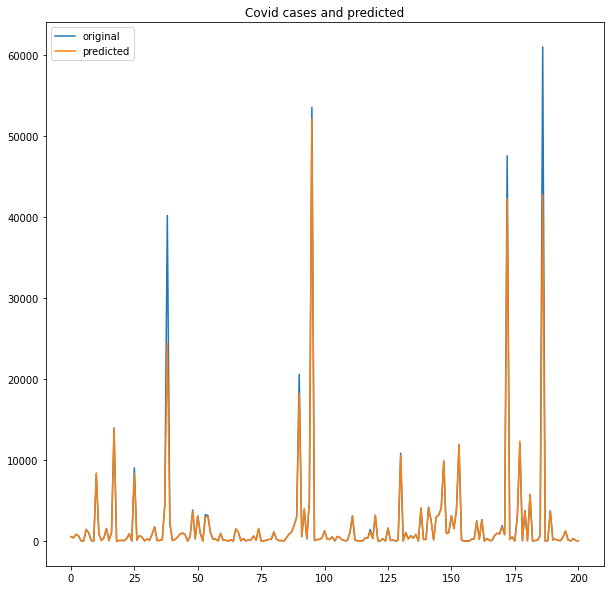

In [407]:
rcParams['figure.figsize'] = 10, 10

x_ax = range(len(y))
plt.plot(x_ax, y, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Covid cases and predicted")
plt.legend()
plt.show()

In [408]:
evaluate(model, X, y)

1777.2848097625658